# Car Classifier SVM Training

In [57]:
import glob
import os
import numpy as np
from scipy.ndimage.measurements import label
from skimage.feature import hog
from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC
import cv2
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from imp import reload

from IPython.display import display, HTML
%matplotlib inline

import feature_extractor
reload(feature_extractor)
from feature_extractor import FeatureExtractor

import car_finder
reload(car_finder)
from car_finder import CarFinder

In [58]:
# Configurations - Tweak these parameters to fine tune results.
color_space = 'YCrCb'  # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8  # HOG pixels per cell
cell_per_block = 2  # HOG cells per block
hog_channel = 'ALL'  # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32)  # Spatial binning dimensions
hist_bins = 32  # Number of histogram bins
spatial_feat = True  # Spatial features on or off
hist_feat = True  # Histogram features on or off
hog_feat = True  # HOG features on or off

feature_extractor = FeatureExtractor()

In [59]:
# artifacts folder
GEN_FOLDER = '../gen'
if not os.path.exists(GEN_FOLDER):
    os.makedirs(GEN_FOLDER)
    print("artifacts folder '{}' created".format(GEN_FOLDER))
else:
    print("artifacts folder '{}' already exists".format(GEN_FOLDER))

artifacts folder '../gen' created


In [60]:
# Load in cars and not_cars images
images = glob.glob('../training_data/*/*/*.png')

cars = []
not_cars = []
for image in images:
    if 'non-vehicles' in image:
        not_cars.append(image)
    else:
        cars.append(image)

print("Cars:", len(cars))
print("Not Cars:", len(not_cars))

Cars: 8792
Not Cars: 9666


## Visual Data

### Helpers

In [61]:
def get_random_image(image_paths):
    """Returns a random image from a file path"""
    random_index = np.random.randint(len(image_paths))
    image_path = image_paths[random_index]
    img = cv2.imread(image_path)
    return img

def read_image(image_path):
    """Returns a RGB formatted image from a file path"""
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def show_samples(data, title):
    """Plots random images from the training set"""
    plt.figure(figsize=(10, 4))
    img_num = 1
    show_samples_count = 5

    for i in range(show_samples_count):
        plt.subplot(1, show_samples_count, img_num)   
        img_num += 1
        img = get_random_image(data)
        plt.imshow(img)
        plt.title("{}".format(title), fontsize=10)
        plt.axis('off')

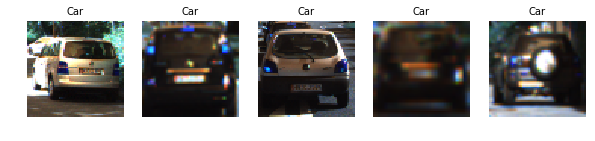

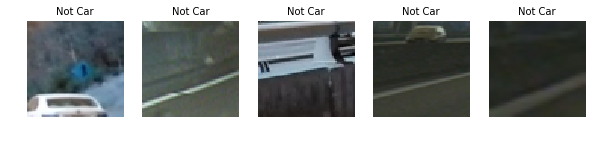

In [62]:
show_samples(cars, "Car")
show_samples(not_cars, "Not Car")

### Visualize Histogram of Gradients

/Users/kmartin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


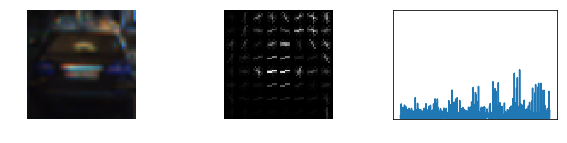

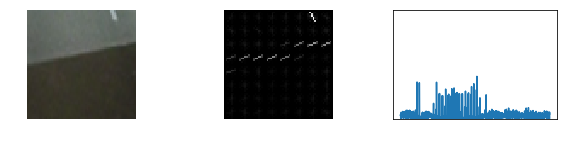

In [63]:
def plot_hog_sample(image, hog_image, hog_features):
    """Plots a orignal image, HOG image and HOG histogram"""
    plt.figure(figsize=(10,2))
    plt.subplot(1,3,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,3,2)
    plt.imshow(hog_image, cmap='gray')
    plt.axis('off')
    plt.subplot(1,3,3)
    plt.plot(hog_features)
    plt.ylim(0,1)
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive example
image = get_random_image(cars)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = feature_extractor.get_hog_features(gray_image, orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

# plot negative example
image = get_random_image(not_cars)
gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
hog_features, hog_image = feature_extractor.get_hog_features(gray_image, orient=orient, 
                                           pix_per_cell=pix_per_cell, 
                                           cell_per_block=cell_per_block, vis=True)
plot_hog_sample(image, hog_image, hog_features)

### Visualize Color Histogram

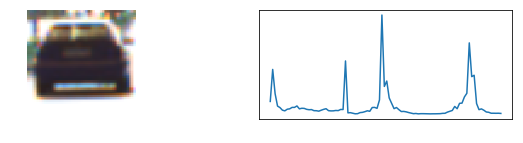

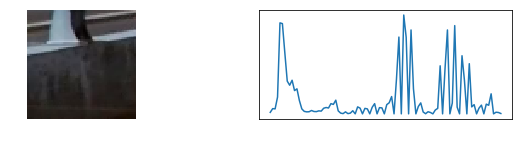

In [64]:
def plot_color_histogram_sample(image, yuv_image):
    """Plots image and it's color histogram"""
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(feature_extractor.color_hist(yuv_image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()
    
# plot positive example
image = get_random_image(cars)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

# plot negative example
image = get_random_image(not_cars)
yuv_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
plot_color_histogram_sample(image, yuv_image)

### Visualize Color Binning

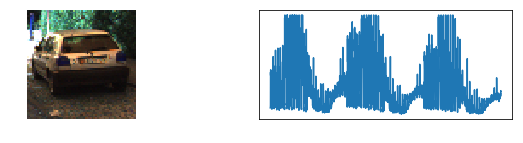

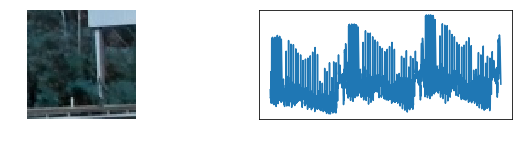

In [65]:
def plot_bin_spatial_sample(image):
    """Plot image and it's spacial color histogram"""
    plt.figure(figsize=(10,2))
    plt.subplot(1,2,1)
    plt.imshow(image)
    plt.axis('off')
    plt.subplot(1,2,2)
    plt.plot(feature_extractor.bin_spatial(image))
    plt.tick_params(axis='x', which='both', bottom='off', top='off', labelbottom='off')
    plt.tick_params(axis='y', which='both', left='off', right='off', labelleft='off')
    plt.show()

# plot positive example
image = get_random_image(cars)
plot_bin_spatial_sample(image)

# plot negative example
image = get_random_image(not_cars)
plot_bin_spatial_sample(image)

### Feature Extraction and Scaling

In [66]:
car_features = feature_extractor.extract_features(cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Car Features: {} x {}".format(len(car_features), len(car_features[0])))

notcar_features = feature_extractor.extract_features(not_cars, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

print("Not Car Features: {} x {}".format(len(notcar_features), len(notcar_features[0])))

X = np.vstack((car_features, notcar_features)).astype(np.float64)

# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)

# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))

print("Feature scaling complete")

/Users/kmartin/anaconda/envs/carnd-term1/lib/python3.5/site-packages/skimage/feature/_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


Car Features: 8792 x 8460
Not Car Features: 9666 x 8460
Feature scaling complete


### Save Features and Labels

In [67]:
# save features
fn = GEN_FOLDER + '/features_scaled_X.pkl'
joblib.dump(scaled_X, fn) 

# save labels
fn = GEN_FOLDER + '/labels_y.pkl'
joblib.dump(y, fn)

print("Features and labels saved")

Features and labels saved


### Load Features and Labels

In [68]:
scaled_X = joblib.load(GEN_FOLDER + '/features_scaled_X.pkl') 
y = joblib.load(GEN_FOLDER + '/labels_y.pkl') 

print("Features and labels loaded")

Features and labels loaded


### Split Train Test dataset

In [69]:
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    scaled_X, y, test_size=0.2, random_state=rand_state)

print("X_train:", len(X_train))
print("X_test:", len(X_test))
print("y_train:", len(y_train))
print("y_test:", len(y_test))

X_train: 14766
X_test: 3692
y_train: 14766
y_test: 3692


### Train SVM classifier

In [70]:
import time

print('Using:', orient, 'orientations', pix_per_cell,'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

# Use a linear SVC 
from sklearn.svm import SVC
from sklearn.svm import LinearSVC
svc = LinearSVC()

# Check the training time for the SVC
t=time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test accuracy of SVC = ', round(svc.score(X_test, y_test), 4))

# Check the prediction time for a single sample
predictions = svc.predict(X_test)

Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
40.63 Seconds to train SVC...
Test accuracy of SVC =  0.9913


### Metrics and Confusion Matrix

In [71]:
from sklearn.metrics import make_scorer, confusion_matrix, roc_curve, auc
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=None):
    
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm, cmap=cmap)
    
    for (i, j), z in np.ndenumerate(cm):
        ax.text(j, i, '{:0.1f}'.format(z), ha='center', va='center')

    plt.title(title+ "\n")
    fig.colorbar(cax)
    if labels:
        ax.set_xticklabels([''] + labels)
        ax.set_yticklabels([''] + labels)

    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.savefig(GEN_FOLDER + '/confusionmatrix.png')

Accuracy Score: 0.991332611051
F1 Score: 0.991311959939
Precision Score: 0.991311959939
Recall Score: 0.991311959939


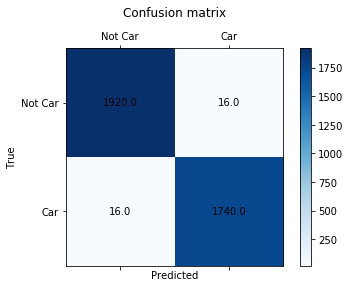

In [72]:
# calculate metrics
print("Accuracy Score:", accuracy_score(y_test, predictions))
print("F1 Score:", f1_score(y_test, predictions, average="macro"))
print("Precision Score:", precision_score(y_test, predictions, average="macro"))
print("Recall Score:", recall_score(y_test, predictions, average="macro")) 

# sklearn confusion matrix 
cm = confusion_matrix(predictions, y_test)

# plot using matplotlib
plot_confusion_matrix(cm, labels = ['Not Car', 'Car'])

### Save Trained SVM Classifier

In [74]:
from sklearn.externals import joblib

## save svc
fn = GEN_FOLDER + '/svc.pkl'
with open(fn, 'wb') as f:
    pickle.dump(svc, file=f)

## save x_scaler
fn = GEN_FOLDER + '/x_scaler.pkl'
joblib.dump(X_scaler, fn) 

print('Scaled training data save')
print('SVM model saved')

NameError: name 'pickle' is not defined